## IMPORT TOOLS AND LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, r2_score

from joblib import dump, load

randomseed = 15
pd.set_option('display.width', 1000000000)

## DATA HANDLING

##### IMPORT DATA

In [2]:
flatPrices = pd.read_csv('flat-prices-new.csv')
flatPrices = flatPrices.drop([flatPrices.columns[0]], axis=1)
print(flatPrices)
flatPrices.info()

             month        town         flat_type block        street_name storey_range  floor_area_sqm        flat_model lease_commence_date  remaining_lease  resale_price
0       2017-01-01  ANG MO KIO            2 ROOM   406  ANG MO KIO AVE 10     10 TO 12            44.0          Improved          1979-05-12        61.333333      232000.0
1       2017-01-01  ANG MO KIO            3 ROOM   108   ANG MO KIO AVE 4     01 TO 03            67.0    New Generation          1978-08-11        60.583333      250000.0
2       2017-01-01  ANG MO KIO            3 ROOM   602   ANG MO KIO AVE 5     01 TO 03            67.0    New Generation          1980-06-11        62.416667      262000.0
3       2017-01-01  ANG MO KIO            3 ROOM   465  ANG MO KIO AVE 10     04 TO 06            68.0    New Generation          1980-02-10        62.083333      265000.0
4       2017-01-01  ANG MO KIO            3 ROOM   601   ANG MO KIO AVE 5     01 TO 03            67.0    New Generation          1980-06-11

#####  CONVERT DATE COLUMNS INTO INTEGERS

In [3]:
flatPrices['month'] = flatPrices['month'].astype(str).replace('-', '', regex=True).astype(int)
flatPrices['lease_commence_date'] = flatPrices['lease_commence_date'].astype(str).replace('-', '', regex=True).astype(int)

##### CONVERT CATEGORICAL COLUMNS INTO NUMBERS USING PANDAS

In [4]:
for label, content in flatPrices.items():
    if pd.api.types.is_string_dtype(content):
        flatPrices[label] = content.astype('category')
        flatPrices[label] = pd.Categorical(flatPrices[label]).codes

In [5]:
flatPrices.info()
flatPrices

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125464 entries, 0 to 125463
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                125464 non-null  int32  
 1   town                 125464 non-null  int8   
 2   flat_type            125464 non-null  int8   
 3   block                125464 non-null  int16  
 4   street_name          125464 non-null  int16  
 5   storey_range         125464 non-null  int8   
 6   floor_area_sqm       125464 non-null  float64
 7   flat_model           125464 non-null  int8   
 8   lease_commence_date  125464 non-null  int32  
 9   remaining_lease      125464 non-null  float64
 10  resale_price         125464 non-null  float64
dtypes: float64(3), int16(2), int32(2), int8(4)
memory usage: 4.8 MB


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,20170101,0,1,1084,13,3,44.0,4,19790512,61.333333,232000.0
1,20170101,0,2,35,16,0,67.0,11,19780811,60.583333,250000.0
2,20170101,0,2,1662,17,0,67.0,11,19800611,62.416667,262000.0
3,20170101,0,2,1262,13,1,68.0,11,19800210,62.083333,265000.0
4,20170101,0,2,1657,17,0,67.0,11,19800611,62.416667,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
125459,20220401,25,5,2269,549,0,142.0,2,19880208,64.833333,739388.0
125460,20220401,25,5,2284,549,2,142.0,2,19880309,64.916667,773000.0
125461,20220101,25,6,1751,546,1,164.0,10,19870110,64.000000,785000.0
125462,20220201,25,6,1751,546,1,171.0,10,19880110,64.916667,842000.0


##### SPLIT DATA INTO INTO TRAIN, VALIDATION AND TEST SETS

In [6]:
train_end = int(len(flatPrices) * 0.7)
valid_end = int(len(flatPrices) * 0.85)

X_train, y_train = flatPrices[:train_end].drop('resale_price', axis=1), flatPrices[:train_end]['resale_price']
X_valid, y_valid = flatPrices[train_end:valid_end].drop('resale_price', axis=1), flatPrices[train_end:valid_end]['resale_price']
X_test, y_test = flatPrices[valid_end:].drop('resale_price', axis=1), flatPrices[valid_end:]['resale_price']

## TRAIN AND CONDUCT INITIAL MODEL TEST

##### TRAIN RANDOMFORESTREGRESSOR MODEL

In [7]:
randForReg = RandomForestRegressor(n_jobs=-1, random_state=randomseed)
randForInitialParams = randForReg.get_params()
print(pd.DataFrame(randForInitialParams, index=['RandomForestRegressor']).transpose())
randForReg.fit(X_train, y_train)

                         RandomForestRegressor
bootstrap                                 True
ccp_alpha                                  0.0
criterion                        squared_error
max_depth                                 None
max_features                              auto
max_leaf_nodes                            None
max_samples                               None
min_impurity_decrease                      0.0
min_samples_leaf                             1
min_samples_split                            2
min_weight_fraction_leaf                   0.0
n_estimators                               100
n_jobs                                      -1
oob_score                                False
random_state                                15
verbose                                      0
warm_start                               False


RandomForestRegressor(n_jobs=-1, random_state=15)

#####  TRAIN DECISIONTREEREGRESSOR MODEL

In [8]:
decTreeReg = DecisionTreeRegressor(random_state=randomseed)
decTreeInitialParams = decTreeReg.get_params()
print(pd.DataFrame(decTreeInitialParams, index=['DecisionTreeRegressor']).transpose())
decTreeReg.fit(X_train, y_train)

                         DecisionTreeRegressor
ccp_alpha                                  0.0
criterion                        squared_error
max_depth                                 None
max_features                              None
max_leaf_nodes                            None
min_impurity_decrease                      0.0
min_samples_leaf                             1
min_samples_split                            2
min_weight_fraction_leaf                   0.0
random_state                                15
splitter                                  best


DecisionTreeRegressor(random_state=15)

##### INITIALISE MODELS AND CONDUCT INITIAL TEST

In [9]:
initial_models = {'RandomForestRegressor': randForReg,
                  'DecisionTreeRegressor': decTreeReg}

def evaluate_models(models, xtest, ytest):
    mean_abs_err = {}
    med_abs_err = {}
    root_mean_sqr_err = {}
    mean_abs_perc_err = {}
    mean_sqr_log_err = {}
    r2_scr = {}

    for name, model in models.items():
        print(f'Testing {name} Model...')
        ypred = model.predict(xtest)

        mean_abs_err[name] = mean_absolute_error(ytest, ypred)
        med_abs_err[name] = median_absolute_error(ytest, ypred)
        root_mean_sqr_err[name] = (mean_squared_error(ytest, ypred)) ** 0.5
        mean_abs_perc_err[name] = mean_absolute_percentage_error(ytest, ypred)
        mean_sqr_log_err[name] = mean_squared_log_error(ytest, ypred)
        r2_scr[name] = r2_score(ytest, ypred)
    
    return [mean_abs_err, med_abs_err, root_mean_sqr_err, mean_abs_perc_err, mean_sqr_log_err, r2_scr]

initial_results = evaluate_models(initial_models, X_valid, y_valid)

Testing RandomForestRegressor Model...
Testing DecisionTreeRegressor Model...


##### VISUALISE AND COMPARE INITIAL TEST RESULTS

Initial Test Results
                                RandomForestRegressor  DecisionTreeRegressor
Mean Absolute Error                      41616.314345           47688.017751
Median Absolute Error                    32624.220000           35000.000000
Root Mean Squared Error                  57364.057141           68666.224311
Mean Absolute Percentage Error               0.078719               0.091499
Mean Squared Log Error                       0.011486               0.017291
R2 Score                                     0.890195               0.842664


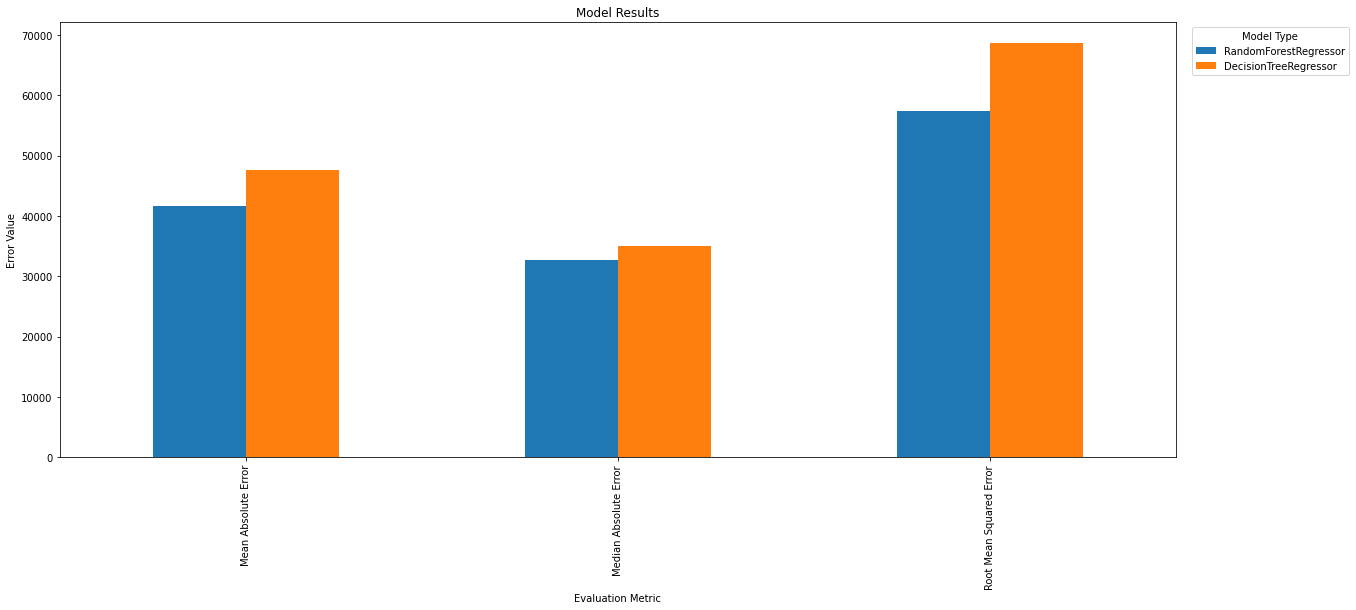

In [10]:
def visualise_results(results):
    results = pd.DataFrame(results, index=['Mean Absolute Error', 'Median Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'Mean Squared Log Error', 'R2 Score'])
    print(results)
    error_results_bar = results[:3].plot.bar(figsize=(20, 8), xlabel='Evaluation Metric', ylabel='Error Value', title='Model Results')
    error_results_bar.legend(title='Model Type', bbox_to_anchor=(1.01, 1));

print('Initial Test Results')
visualise_results(initial_results)

## MODEL TUNING AND IMPROVEMENT

##### TUNE AND TRAIN RANDOMFORESTREGRESSOR
TESTED HYPERPARAMETERS:
- 'n_estimators': [100, 200, 300],
- 'max_features': ['auto', 'sqrt'],
- 'max_depth': [39, 44, 50],
- 'min_samples_split': [2, 3, 4],
- 'min_samples_leaf': [1, 3, 5],
- 'bootstrap': [True, False]

In [11]:
gs_randForest_grid = {'n_estimators': [300],
                      'max_features': ['sqrt'],
                      'max_depth': [44],
                      'min_samples_split': [2],
                      'min_samples_leaf': [1],
                      'bootstrap': [False]}

gs_randForest = GridSearchCV(estimator=initial_models['RandomForestRegressor'],
                             param_grid=gs_randForest_grid,
                             cv=5,
                             verbose=2)
gs_randForest.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, max_depth=44, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  12.3s
[CV] END bootstrap=False, max_depth=44, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.5s
[CV] END bootstrap=False, max_depth=44, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.5s
[CV] END bootstrap=False, max_depth=44, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.6s
[CV] END bootstrap=False, max_depth=44, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.4s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=15),
             param_grid={'bootstrap': [False], 'max_depth': [44],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             verbose=2)

##### SHOW BEST PARAMETERS FOR RANDOMFORESTREGRESSOR MODEL

In [12]:
randForBestParams = gs_randForest.best_params_
print(pd.DataFrame(randForBestParams, index=['RandomForestRegressor']).transpose())

                  RandomForestRegressor
bootstrap                         False
max_depth                            44
max_features                       sqrt
min_samples_leaf                      1
min_samples_split                     2
n_estimators                        300


##### TUNE AND TRAIN DECISIONTREEREGRESSOR

TESTED HYPERPARAMETERS:
- 'splitter': ['best', 'random'],
- 'max_depth' : [None, 1, 3, 5],
- 'min_samples_leaf': [1, 3, 5, 7],
- 'min_weight_fraction_leaf': [0, 0.5, 1, 3],
- 'max_features': ['auto', 'sqrt'],
- 'max_leaf_nodes': [None, 10, 40, 80]


In [13]:
gs_decTreeReg_grid={'splitter': ['best'],
                    'max_depth' : [None],
                    'min_samples_leaf': [3],
                    'min_weight_fraction_leaf': [0],
                    'max_features': ['auto'],
                    'max_leaf_nodes': [None]}

gs_decTreeReg = GridSearchCV(estimator=initial_models['DecisionTreeRegressor'],
                             param_grid=gs_decTreeReg_grid,
                             cv=5,
                             verbose=2)
gs_decTreeReg.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0, splitter=best; total time=   0.4s
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0, splitter=best; total time=   0.4s
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0, splitter=best; total time=   0.4s
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0, splitter=best; total time=   0.4s
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0, splitter=best; total time=   0.3s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=15),
             param_grid={'max_depth': [None], 'max_features': ['auto'],
                         'max_leaf_nodes': [None], 'min_samples_leaf': [3],
                         'min_weight_fraction_leaf': [0],
                         'splitter': ['best']},
             verbose=2)

##### SHOW BEST PARAMETERS FOR DECISIONTREEREGRESSOR

In [14]:
decTreeBestParams = gs_decTreeReg.best_params_
print(pd.DataFrame(decTreeBestParams, index=['DecisionTreeRegressor']).transpose())

                         DecisionTreeRegressor
max_depth                                 None
max_features                              auto
max_leaf_nodes                            None
min_samples_leaf                             3
min_weight_fraction_leaf                     0
splitter                                  best


##### INITIALISE AND TEST TUNED MODELS

In [15]:
tuned_models = {'RandomForestRegressor': gs_randForest,
                'DecisionTreeRegressor': gs_decTreeReg}

tuned_results = evaluate_models(tuned_models, X_valid, y_valid)

Testing RandomForestRegressor Model...
Testing DecisionTreeRegressor Model...


##### VISUALISE TUNED MODEL RESULTS

Tuned Test Results
                                RandomForestRegressor  DecisionTreeRegressor
Mean Absolute Error                      40077.555218           46815.537533
Median Absolute Error                    31965.786667           35811.200000
Root Mean Squared Error                  53876.099382           66122.273029
Mean Absolute Percentage Error               0.075616               0.089458
Mean Squared Log Error                       0.010223               0.015714
R2 Score                                     0.903142               0.854106


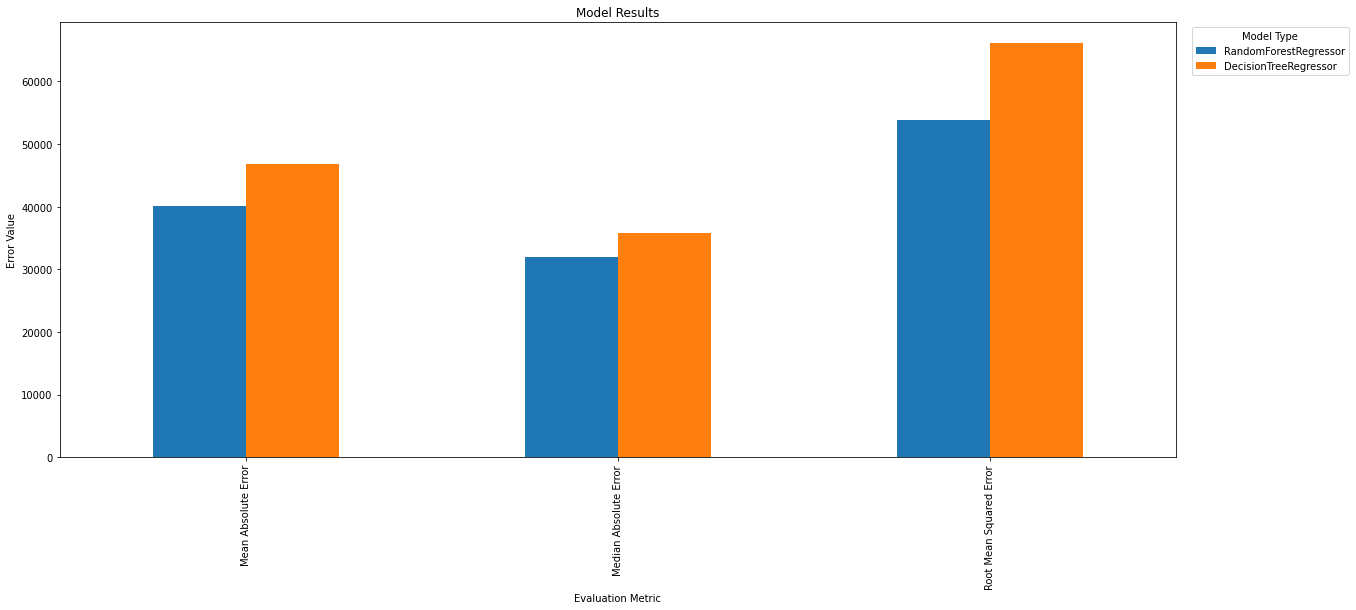

In [16]:
print('Tuned Test Results')
visualise_results(tuned_results)

## MODEL EVALUATION

##### FINAL MODEL TEST

Testing RandomForestRegressor Model...
Testing DecisionTreeRegressor Model...
Final Results
                                RandomForestRegressor  DecisionTreeRegressor
Mean Absolute Error                      55196.202937           60239.159234
Median Absolute Error                    49293.520000           51983.200000
Root Mean Squared Error                  68862.444136           77072.609408
Mean Absolute Percentage Error               0.106103               0.116055
Mean Squared Log Error                       0.018374               0.023775
R2 Score                                     0.798326               0.747370


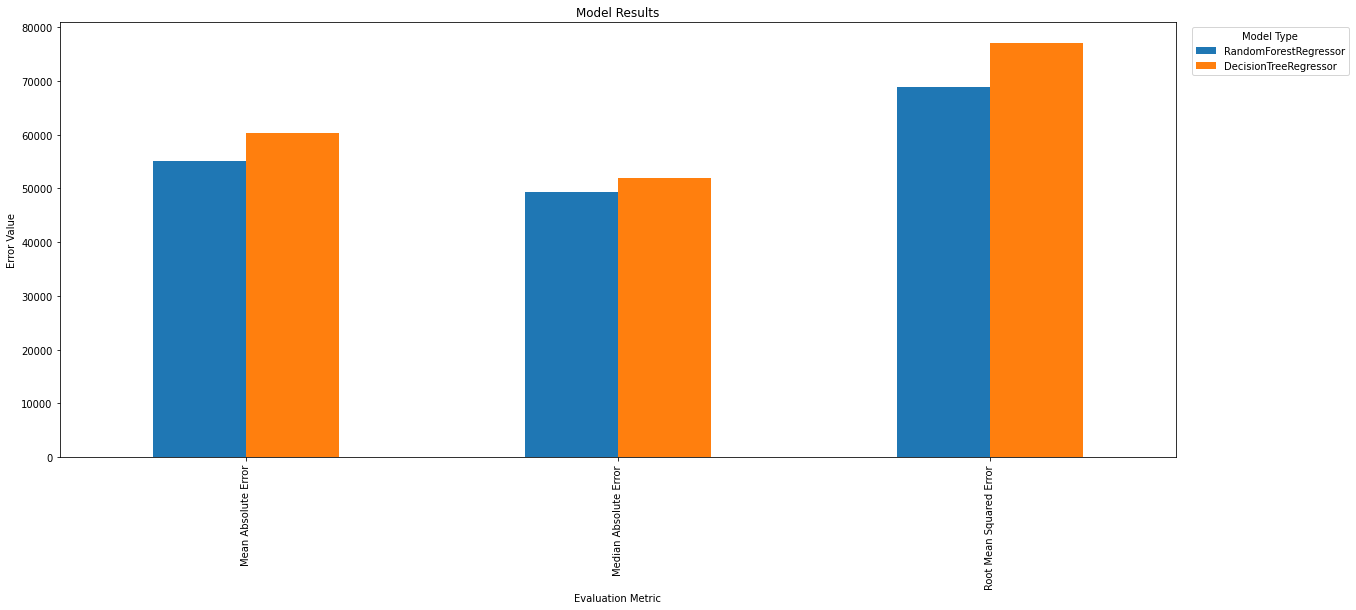

In [17]:
final_model = {'RandomForestRegressor': gs_randForest,
               'DecisionTreeRegressor': gs_decTreeReg}
final_results = evaluate_models(final_model, X_test, y_test)
print('Final Results')
visualise_results(final_results)

##### FEATURE IMPORTANCE

,RandomForestRegressor,DecisionTreeRegressor
month,0.009377,0.009207
remaining_lease,0.013827,0.009692
flat_type,0.015408,0.010799
block,0.043452,0.045753
flat_model,0.045026,0.048501
street_name,0.062198,0.057353
lease_commence_date,0.097493,0.098226
storey_range,0.122318,0.123362
town,0.144235,0.146892
floor_area_sqm,0.446666,0.450215


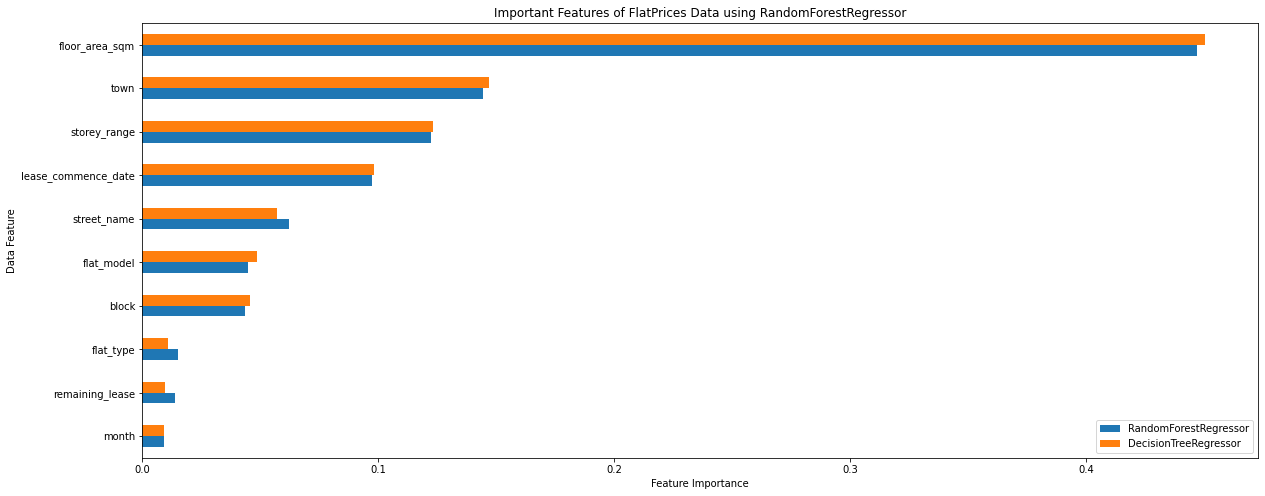

In [18]:
featImptData = {'RandomForestRegressor': initial_models['RandomForestRegressor'].feature_importances_,
                'DecisionTreeRegressor': initial_models['DecisionTreeRegressor'].feature_importances_}
featImptFig, featImptAx = plt.subplots(figsize=(20, 8))
featImpt = pd.DataFrame(featImptData, index=list(X_train.columns)).sort_values('RandomForestRegressor')
featImpt.plot.barh(ax=featImptAx)
featImptAx.set(xlabel='Feature Importance', ylabel='Data Feature', title='Important Features of FlatPrices Data using RandomForestRegressor');
featImpt

## SAVE AND LOAD MODEL
- RANDOMFORESTREGRESSOR MODEL WILL BE USED SINCE IT OUTPERFORMS DECISIONTREEREGRESSOR MODEL AFTER TUNING AND FINAL EVALUATION

##### SAVE MODEL

In [19]:
dump(gs_randForest, filename='FlatPricesModel.joblib')

['FlatPricesModel.joblib']

##### LOAD MODEL AND ENSURE SUCCESSFUL LOADING OF MODEL

Testing FlatPricesModel Model...
                                FlatPricesModel
Mean Absolute Error                55196.202937
Median Absolute Error              49293.520000
Root Mean Squared Error            68862.444136
Mean Absolute Percentage Error         0.106103
Mean Squared Log Error                 0.018374
R2 Score                               0.798326


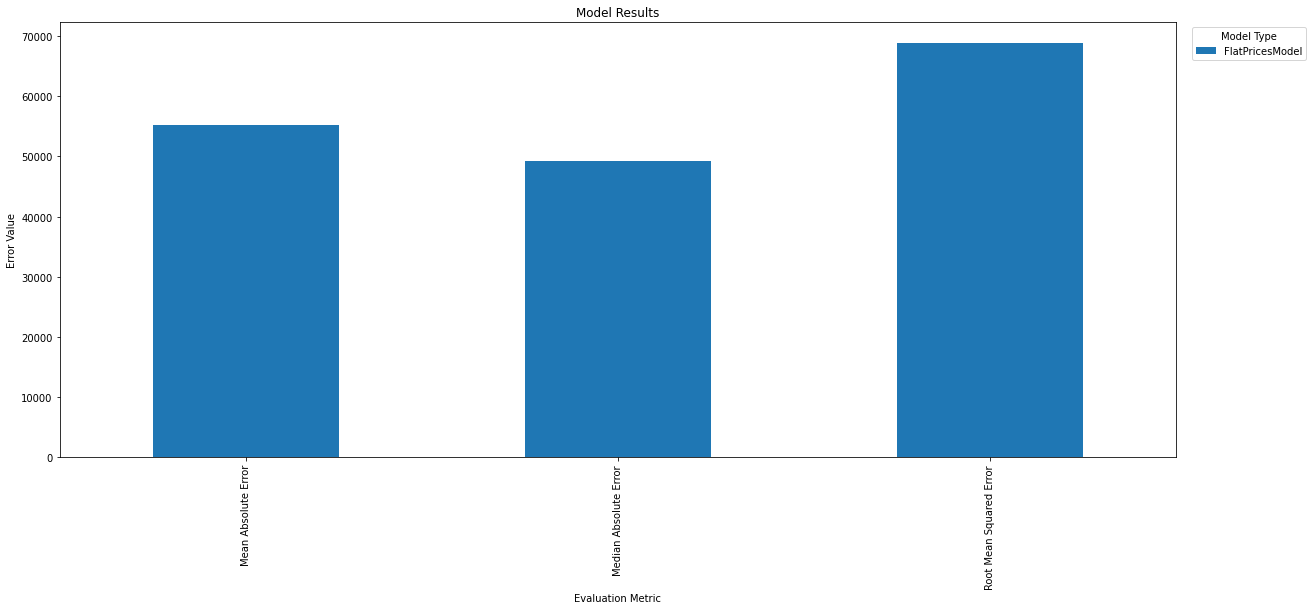

In [20]:
flatPricesModel = load(filename='FlatPricesModel.joblib')
loaded_model = {'FlatPricesModel': flatPricesModel}
loadedModelResults = evaluate_models(loaded_model, X_test, y_test)
visualise_results(loadedModelResults)